In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Define dataset path
dataset_path = "/content/drive/MyDrive/dl chest/dl chest"  # Update this with the correct path

# Define categories
categories = ["NORMAL", "PNEUMONIA"]

# Function to count images in each category
def count_images(dataset_path):
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            num_images = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"📂 {category}: {num_images} images")
        else:
            print(f"❌ {category} folder not found!")

# Run the function
count_images(dataset_path)


📂 NORMAL: 1635 images
📂 PNEUMONIA: 4312 images


In [ ]:
import os
import shutil
import random

# Define paths
original_dataset_dir ="/content/drive/MyDrive/dl chest/dl chest"  # Update with actual dataset path
base_dir = "/content/drive/MyDrive/dl split chest images"  # Update with actual path where you want the split dataset to be stored

# Define train, test, and val directories
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# Define categories
categories = ["NORMAL", "PNEUMONIA"]

# Create required directories
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

# Function to split dataset
def split_data(source, train_dest, test_dest, val_dest, train_ratio=0.85, test_ratio=0.15, val_ratio=0.005, move_files=True):
    files = [f for f in os.listdir(source) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]  # Filter only images
    random.shuffle(files)  # Shuffle images to ensure randomness

    total_files = len(files)
    train_count = int(total_files * train_ratio)
    test_count = int(total_files * test_ratio)
    val_count = max(1, int(total_files * val_ratio))  # Ensure at least one file for validation

    train_files = files[:train_count]
    test_files = files[train_count:train_count + test_count]
    val_files = files[train_count + test_count:train_count + test_count + val_count]

    # Function to move or copy files
    def transfer_files(file_list, dest_folder):
        for f in file_list:
            src_path = os.path.join(source, f)
            dest_path = os.path.join(dest_folder, f)
            if not os.path.exists(dest_path):  # Avoid overwriting
                if move_files:
                    shutil.move(src_path, dest_path)
                else:
                    shutil.copy(src_path, dest_path)

    # Transfer files
    transfer_files(train_files, train_dest)
    transfer_files(test_files, test_dest)
    transfer_files(val_files, val_dest)

    print(f"Moved {len(train_files)} images to {train_dest}")
    print(f"Moved {len(test_files)} images to {test_dest}")
    print(f"Moved {len(val_files)} images to {val_dest}")

# Apply function to both NORMAL and PNEUMONIA images
for category in categories:
    source_folder = os.path.join(original_dataset_dir, category)
    split_data(source_folder, os.path.join(train_dir, category), os.path.join(test_dir, category), os.path.join(val_dir, category))

print("\n✅ Dataset splitting complete!")


Moved 1389 images to /content/drive/MyDrive/dl split chest images/train/NORMAL
Moved 245 images to /content/drive/MyDrive/dl split chest images/test/NORMAL
Moved 1 images to /content/drive/MyDrive/dl split chest images/val/NORMAL
Moved 3665 images to /content/drive/MyDrive/dl split chest images/train/PNEUMONIA
Moved 646 images to /content/drive/MyDrive/dl split chest images/test/PNEUMONIA
Moved 1 images to /content/drive/MyDrive/dl split chest images/val/PNEUMONIA

✅ Dataset splitting complete!


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Define dataset directories
data_dir = r"C:\New folder\dl split chest images"  # Update with correct path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Verify dataset paths exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("❌ ERROR: Train or test directory not found! Check the dataset path.")

# Image Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset with binary classification
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# Function to visualize data augmentation
def visualize_augmentation(generator, num_images=5):
    """Displays original and augmented images."""
    sample_images, _ = next(generator)  # Get a batch of images
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        img = sample_images[i]  # Original image
        augmented_img = train_datagen.random_transform(img)  # Apply augmentation

        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Original")

        # Display augmented image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(augmented_img)
        plt.axis("off")
        plt.title("Augmented")

    plt.suptitle("Original vs Augmented Images")
    plt.show()

# Function to create and fine-tune DenseNet201 model
def create_model(fine_tune_at=50):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze all layers

    # Freeze first few layers and fine-tune deeper layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
    output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate():
    print("🚀 Training DenseNet201 model...")

    model = create_model()

    # Define callbacks
    checkpoint = ModelCheckpoint("DenseNet201_best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

    # Train model
    history = model.fit(
        train_generator, epochs=50, validation_data=test_generator, callbacks=[checkpoint, reduce_lr])

    print("✅ DenseNet201 model training complete! Best model saved as 'DenseNet201_best_model.h5'")

    # Plot Training & Validation Accuracy and Loss
    plot_training_history(history)

    evaluate_model()

# Function to plot training history
def plot_training_history(history):
    """Plots training & validation accuracy and loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

# Function to evaluate a trained DenseNet201 model
def evaluate_model():
    print("\n📊 Evaluating DenseNet201 Model...")

    # Load the best saved model
    model = tf.keras.models.load_model("DenseNet201_best_model.h5")

    # Get ground truth labels and predictions
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    # Compute evaluation metrics
    print("\n🔍 Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - DenseNet201")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - DenseNet201')
    plt.legend(loc='lower right')
    plt.show()

    print(f"📌 DenseNet201 AUC Score: {roc_auc:.4f}")

# Run augmentation visualization, training, and evaluation
visualize_augmentation(train_generator)
train_and_evaluate()


Found 5054 images belonging to 2 classes.



Found 891 images belonging to 2 classes.

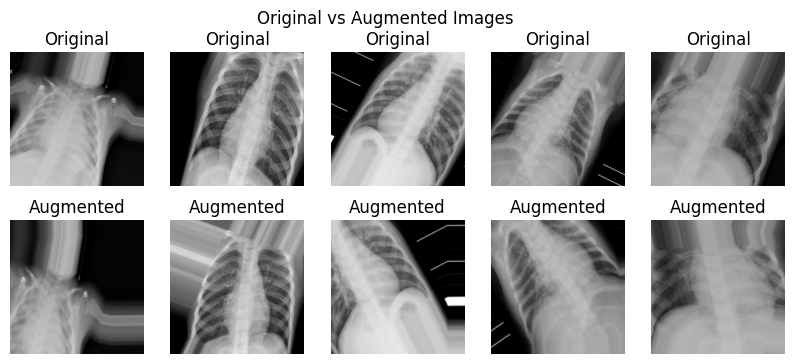



```
# 📊 Evaluating DenseNet201 Model...
WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
[1m28/28[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m79s[0m 3s/step

🔍 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.94      0.94       245
   PNEUMONIA       0.98      0.98      0.98       646

    accuracy                           0.97       891
   macro avg       0.96      0.96      0.96       891
weighted avg       0.97      0.97      0.97       891
```







```
# 🚀 Training DenseNet201 model...
c:\Users\Manoj.L\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Epoch 1/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 7s/step - accuracy: 0.7403 - loss: 0.5120WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1284s[0m 8s/step - accuracy: 0.7409 - loss: 0.5112 - val_accuracy: 0.8990 - val_loss: 0.3238 - learning_rate: 1.0000e-05
Epoch 2/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 7s/step - accuracy: 0.9160 - loss: 0.2337WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1209s[0m 8s/step - accuracy: 0.9161 - loss: 0.2336 - val_accuracy: 0.9169 - val_loss: 0.2698 - learning_rate: 1.0000e-05
Epoch 3/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 8s/step - accuracy: 0.9432 - loss: 0.1598WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1373s[0m 9s/step - accuracy: 0.9432 - loss: 0.1598 - val_accuracy: 0.9383 - val_loss: 0.1820 - learning_rate: 1.0000e-05
Epoch 4/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 7s/step - accuracy: 0.9525 - loss: 0.1331WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1223s[0m 8s/step - accuracy: 0.9525 - loss: 0.1330 - val_accuracy: 0.9484 - val_loss: 0.1727 - learning_rate: 1.0000e-05
Epoch 5/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 7s/step - accuracy: 0.9542 - loss: 0.1259WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1226s[0m 8s/step - accuracy: 0.9542 - loss: 0.1259 - val_accuracy: 0.9506 - val_loss: 0.1661 - learning_rate: 1.0000e-05
Epoch 6/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1450s[0m 9s/step - accuracy: 0.9665 - loss: 0.1046 - val_accuracy: 0.9484 - val_loss: 0.1747 - learning_rate: 1.0000e-05
Epoch 7/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 9s/step - accuracy: 0.9703 - loss: 0.0857WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1470s[0m 9s/step - accuracy: 0.9703 - loss: 0.0858 - val_accuracy: 0.9562 - val_loss: 0.1500 - learning_rate: 1.0000e-05
Epoch 8/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 9s/step - accuracy: 0.9693 - loss: 0.0759WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1502s[0m 9s/step - accuracy: 0.9693 - loss: 0.0760 - val_accuracy: 0.9675 - val_loss: 0.0942 - learning_rate: 1.0000e-05
Epoch 9/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1220s[0m 8s/step - accuracy: 0.9736 - loss: 0.0789 - val_accuracy: 0.9529 - val_loss: 0.1596 - learning_rate: 1.0000e-05
Epoch 10/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1129s[0m 7s/step - accuracy: 0.9726 - loss: 0.0780 - val_accuracy: 0.9461 - val_loss: 0.1808 - learning_rate: 1.0000e-05
Epoch 11/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1109s[0m 7s/step - accuracy: 0.9785 - loss: 0.0624 - val_accuracy: 0.9618 - val_loss: 0.1349 - learning_rate: 1.0000e-05
Epoch 12/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1135s[0m 7s/step - accuracy: 0.9781 - loss: 0.0589 - val_accuracy: 0.9495 - val_loss: 0.1778 - learning_rate: 2.0000e-06
Epoch 13/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1175s[0m 7s/step - accuracy: 0.9804 - loss: 0.0606 - val_accuracy: 0.9540 - val_loss: 0.1620 - learning_rate: 2.0000e-06
Epoch 14/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1186s[0m 8s/step - accuracy: 0.9739 - loss: 0.0631 - val_accuracy: 0.9618 - val_loss: 0.1421 - learning_rate: 2.0000e-06
Epoch 15/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1137s[0m 7s/step - accuracy: 0.9825 - loss: 0.0535 - val_accuracy: 0.9607 - val_loss: 0.1458 - learning_rate: 4.0000e-07
Epoch 16/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1153s[0m 7s/step - accuracy: 0.9797 - loss: 0.0657 - val_accuracy: 0.9574 - val_loss: 0.1574 - learning_rate: 4.0000e-07
Epoch 17/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1199s[0m 8s/step - accuracy: 0.9817 - loss: 0.0560 - val_accuracy: 0.9585 - val_loss: 0.1560 - learning_rate: 4.0000e-07
Epoch 18/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1213s[0m 8s/step - accuracy: 0.9820 - loss: 0.0516 - val_accuracy: 0.9562 - val_loss: 0.1610 - learning_rate: 1.0000e-07
Epoch 19/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1207s[0m 8s/step - accuracy: 0.9803 - loss: 0.0571 - val_accuracy: 0.9585 - val_loss: 0.1566 - learning_rate: 1.0000e-07
Epoch 20/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1164s[0m 7s/step - accuracy: 0.9865 - loss: 0.0482 - val_accuracy: 0.9562 - val_loss: 0.1620 - learning_rate: 1.0000e-07
Epoch 21/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1168s[0m 7s/step - accuracy: 0.9837 - loss: 0.0540 - val_accuracy: 0.9562 - val_loss: 0.1588 - learning_rate: 1.0000e-07
Epoch 22/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1230s[0m 8s/step - accuracy: 0.9834 - loss: 0.0546 - val_accuracy: 0.9551 - val_loss: 0.1560 - learning_rate: 1.0000e-07
Epoch 23/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1122s[0m 7s/step - accuracy: 0.9767 - loss: 0.0698 - val_accuracy: 0.9574 - val_loss: 0.1536 - learning_rate: 1.0000e-07
Epoch 24/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1160s[0m 7s/step - accuracy: 0.9811 - loss: 0.0519 - val_accuracy: 0.9585 - val_loss: 0.1526 - learning_rate: 1.0000e-07
Epoch 25/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1217s[0m 8s/step - accuracy: 0.9788 - loss: 0.0636 - val_accuracy: 0.9585 - val_loss: 0.1526 - learning_rate: 1.0000e-07
Epoch 26/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1140s[0m 7s/step - accuracy: 0.9841 - loss: 0.0486 - val_accuracy: 0.9585 - val_loss: 0.1520 - learning_rate: 1.0000e-07
Epoch 27/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1133s[0m 7s/step - accuracy: 0.9758 - loss: 0.0665 - val_accuracy: 0.9596 - val_loss: 0.1538 - learning_rate: 1.0000e-07
Epoch 28/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1171s[0m 7s/step - accuracy: 0.9809 - loss: 0.0573 - val_accuracy: 0.9596 - val_loss: 0.1511 - learning_rate: 1.0000e-07
Epoch 29/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1185s[0m 8s/step - accuracy: 0.9805 - loss: 0.0550 - val_accuracy: 0.9596 - val_loss: 0.1550 - learning_rate: 1.0000e-07
Epoch 30/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1135s[0m 7s/step - accuracy: 0.9798 - loss: 0.0601 - val_accuracy: 0.9585 - val_loss: 0.1522 - learning_rate: 1.0000e-07
Epoch 31/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1130s[0m 7s/step - accuracy: 0.9801 - loss: 0.0574 - val_accuracy: 0.9585 - val_loss: 0.1514 - learning_rate: 1.0000e-07
Epoch 32/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1152s[0m 7s/step - accuracy: 0.9811 - loss: 0.0571 - val_accuracy: 0.9596 - val_loss: 0.1499 - learning_rate: 1.0000e-07
Epoch 33/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1137s[0m 7s/step - accuracy: 0.9852 - loss: 0.0490 - val_accuracy: 0.9596 - val_loss: 0.1521 - learning_rate: 1.0000e-07
Epoch 34/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1195s[0m 8s/step - accuracy: 0.9835 - loss: 0.0466 - val_accuracy: 0.9585 - val_loss: 0.1518 - learning_rate: 1.0000e-07
Epoch 35/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1132s[0m 7s/step - accuracy: 0.9856 - loss: 0.0507 - val_accuracy: 0.9596 - val_loss: 0.1561 - learning_rate: 1.0000e-07
Epoch 36/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1138s[0m 7s/step - accuracy: 0.9807 - loss: 0.0589 - val_accuracy: 0.9585 - val_loss: 0.1542 - learning_rate: 1.0000e-07
Epoch 37/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1105s[0m 7s/step - accuracy: 0.9828 - loss: 0.0527 - val_accuracy: 0.9585 - val_loss: 0.1523 - learning_rate: 1.0000e-07
Epoch 38/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1111s[0m 7s/step - accuracy: 0.9823 - loss: 0.0538 - val_accuracy: 0.9585 - val_loss: 0.1553 - learning_rate: 1.0000e-07
Epoch 39/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1116s[0m 7s/step - accuracy: 0.9808 - loss: 0.0564 - val_accuracy: 0.9585 - val_loss: 0.1477 - learning_rate: 1.0000e-07
Epoch 40/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1121s[0m 7s/step - accuracy: 0.9765 - loss: 0.0673 - val_accuracy: 0.9585 - val_loss: 0.1527 - learning_rate: 1.0000e-07
Epoch 41/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1117s[0m 7s/step - accuracy: 0.9772 - loss: 0.0657 - val_accuracy: 0.9574 - val_loss: 0.1556 - learning_rate: 1.0000e-07
Epoch 42/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1124s[0m 7s/step - accuracy: 0.9762 - loss: 0.0652 - val_accuracy: 0.9551 - val_loss: 0.1589 - learning_rate: 1.0000e-07
Epoch 43/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1141s[0m 7s/step - accuracy: 0.9755 - loss: 0.0639 - val_accuracy: 0.9585 - val_loss: 0.1557 - learning_rate: 1.0000e-07
Epoch 44/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1145s[0m 7s/step - accuracy: 0.9835 - loss: 0.0503 - val_accuracy: 0.9596 - val_loss: 0.1536 - learning_rate: 1.0000e-07
Epoch 45/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1213s[0m 8s/step - accuracy: 0.9821 - loss: 0.0514 - val_accuracy: 0.9596 - val_loss: 0.1511 - learning_rate: 1.0000e-07
Epoch 46/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1348s[0m 9s/step - accuracy: 0.9802 - loss: 0.0562 - val_accuracy: 0.9596 - val_loss: 0.1546 - learning_rate: 1.0000e-07
Epoch 47/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1386s[0m 9s/step - accuracy: 0.9857 - loss: 0.0464 - val_accuracy: 0.9585 - val_loss: 0.1524 - learning_rate: 1.0000e-07
Epoch 48/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1380s[0m 9s/step - accuracy: 0.9748 - loss: 0.0663 - val_accuracy: 0.9596 - val_loss: 0.1529 - learning_rate: 1.0000e-07
Epoch 49/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1318s[0m 8s/step - accuracy: 0.9832 - loss: 0.0544 - val_accuracy: 0.9596 - val_loss: 0.1485 - learning_rate: 1.0000e-07
Epoch 50/50
[1m158/158[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1319s[0m 8s/step - accuracy: 0.9760 - loss: 0.0598 - val_accuracy: 0.9562 - val_loss: 0.1567 - learning_rate: 1.0000e-07
✅ DenseNet201 model training complete! Best model saved as 'DenseNet201_best_model.h5'
```



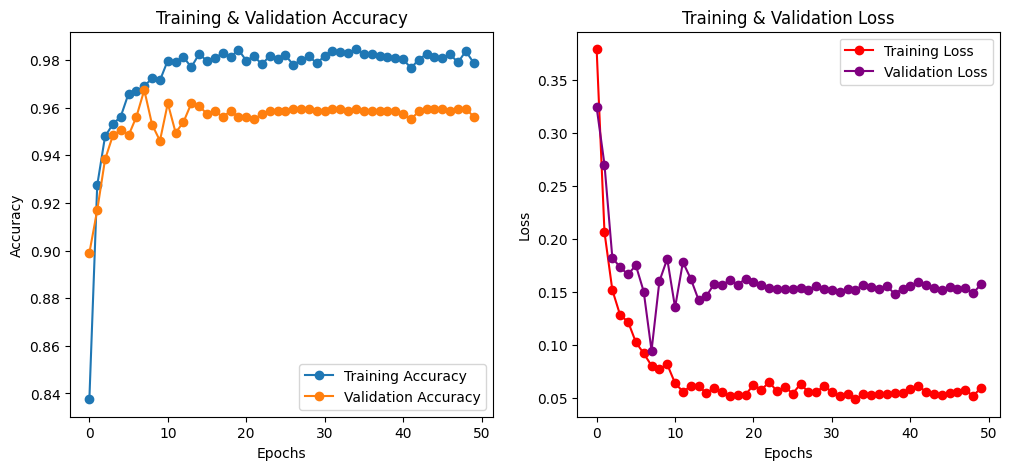

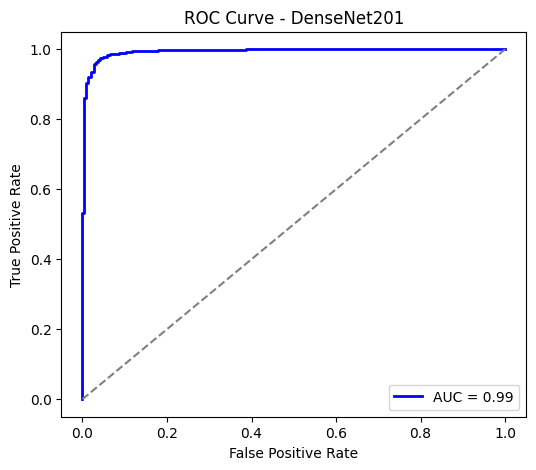

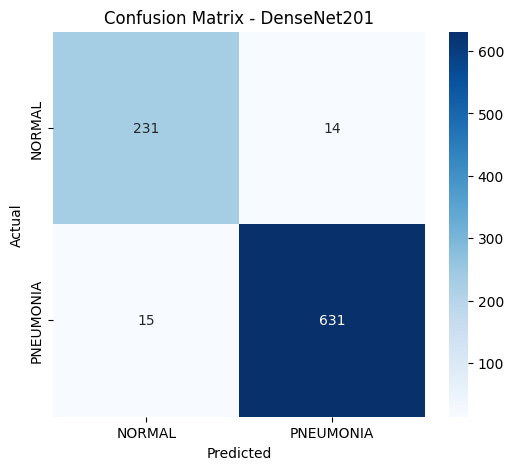

* Dropout Increased → Dropout(0.6) for better regularization.
* Softmax Activation → Changed sigmoid to softmax for improved probability output.
* Sparse Categorical Crossentropy Loss → Adjusted loss function to match softmax.
* Better Fine-Tuning → More layers frozen initially (fine_tune_at=100).
* Improved Training Strategy → Added EarlyStopping for better convergence.
*Precision-Recall Curve Added → Extra metric for evaluation.



Found 5054 images belonging to 2 classes.
Found 891 images belonging to 2 classes.
🚀 Training densenet07 model...
Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7108 - loss: 0.5800 

158/158 ━━━━━━━━━━━━━━━━━━━━ 2334s 12s/step - accuracy: 0.7114 - loss: 0.5791 - val_accuracy: 0.8956 - val_loss: 0.2881 - learning_rate: 1.0000e-05
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.9032 - loss: 0.2460

158/158 ━━━━━━━━━━━━━━━━━━━━ 146s 918ms/step - accuracy: 0.9032 - loss: 0.2459 - val_accuracy: 0.9248 - val_loss: 0.2301 - learning_rate: 1.0000e-05
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.9217 - loss: 0.2092

158/158 ━━━━━━━━━━━━━━━━━━━━ 141s 887ms/step - accuracy: 0.9217 - loss: 0.2091 - val_accuracy: 0.9304 - val_loss: 0.2113 - learning_rate: 1.0000e-05
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.9338 - loss: 0.1882

158/158 ━━━━━━━━━━━━━━━━━━━━ 141s 889ms/step - accuracy: 0.9338 - loss: 0.1881 - val_accuracy: 0.9270 - val_loss: 0.2065 - learning_rate: 1.0000e-05
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.9503 - loss: 0.1433

158/158 ━━━━━━━━━━━━━━━━━━━━ 141s 888ms/step - accuracy: 0.9503 - loss: 0.1432 - val_accuracy: 0.9416 - val_loss: 0.1831 - learning_rate: 1.0000e-05
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.9572 - loss: 0.1171

158/158 ━━━━━━━━━━━━━━━━━━━━ 141s 889ms/step - accuracy: 0.9572 - loss: 0.1171 - val_accuracy: 0.9461 - val_loss: 0.1529 - learning_rate: 1.0000e-05
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.9599 - loss: 0.1171

158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 881ms/step - accuracy: 0.9599 - loss: 0.1171 - val_accuracy: 0.9473 - val_loss: 0.1523 - learning_rate: 1.0000e-05
Epoch 8/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 137s 864ms/step - accuracy: 0.9601 - loss: 0.1094 - val_accuracy: 0.9394 - val_loss: 0.1869 - learning_rate: 1.0000e-05
Epoch 9/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9651 - loss: 0.1025

158/158 ━━━━━━━━━━━━━━━━━━━━ 138s 874ms/step - accuracy: 0.9651 - loss: 0.1025 - val_accuracy: 0.9585 - val_loss: 0.1330 - learning_rate: 1.0000e-05
Epoch 10/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 853ms/step - accuracy: 0.9653 - loss: 0.0975 - val_accuracy: 0.9495 - val_loss: 0.1646 - learning_rate: 1.0000e-05
Epoch 11/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 137s 867ms/step - accuracy: 0.9737 - loss: 0.0817 - val_accuracy: 0.9551 - val_loss: 0.1456 - learning_rate: 1.0000e-05
Epoch 12/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 136s 859ms/step - accuracy: 0.9721 - loss: 0.0828 - val_accuracy: 0.9562 - val_loss: 0.1399 - learning_rate: 1.0000e-05
Epoch 13/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 147s 928ms/step - accuracy: 0.9765 - loss: 0.0695 - val_accuracy: 0.9495 - val_loss: 0.1729 - learning_rate: 1.0000e-05
Epoch 14/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 201s 924ms/step - accuracy: 0.9739 - loss: 0.0644 - val_accuracy: 0.9574 - val_loss: 0.1473 - learning_rate: 1.0000e-05
Epoch 15/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 

28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step

🔍 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.89      0.97      0.93       245
   PNEUMONIA       0.99      0.95      0.97       646

    accuracy                           0.96       891
   macro avg       0.94      0.96      0.95       891
weighted avg       0.96      0.96      0.96       891



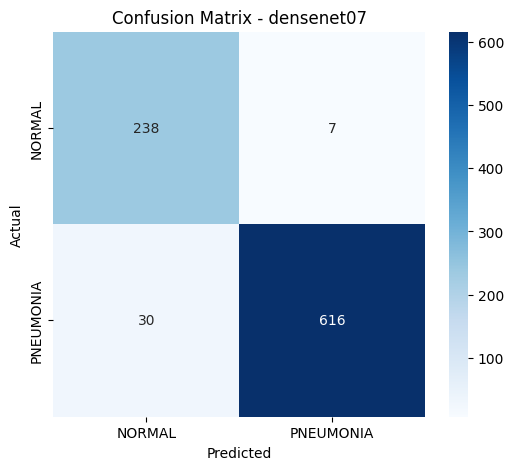

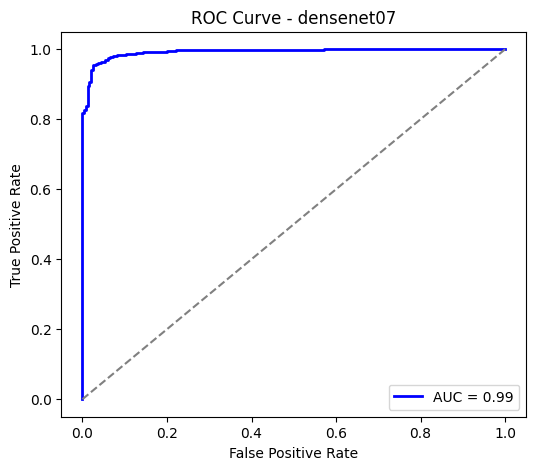

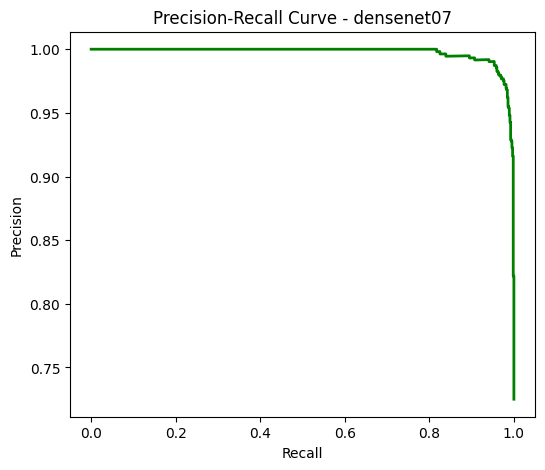

📌 densenet07 AUC Score: 0.9930


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Define dataset directories
data_dir = r"/content/drive/MyDrive/dl split chest images"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Verify dataset paths exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("❌ ERROR: Train or test directory not found! Check the dataset path.")

# Image Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset with binary classification
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# Function to create and fine-tune DenseNet201 model
def create_densenet07(fine_tune_at=100):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True

    # Freeze first few layers and fine-tune deeper layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.6)(x)  # Increased dropout for better regularization
    output_layer = Dense(2, activation='softmax')(x)  # Changed activation to softmax

    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate_densenet07():
    print("🚀 Training densenet07 model...")

    model = create_densenet07()

    # Define callbacks
    checkpoint = ModelCheckpoint("densenet07.h5", monitor='val_loss', save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    # Train model
    model.fit(
        train_generator, epochs=15, validation_data=test_generator, callbacks=[checkpoint, reduce_lr, early_stopping])

    print("✅ densenet07 training complete! Best model saved as 'densenet07.h5'")
    evaluate_densenet07()

def evaluate_densenet07():
    print("\n📊 Evaluating densenet07 Model...")

    model = tf.keras.models.load_model("densenet07.h5")
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    # Classification Report
    print("\n🔍 Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - densenet07")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - densenet07')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(true_labels, predictions[:, 1])
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - densenet07')
    plt.show()

    print(f"📌 densenet07 AUC Score: {roc_auc:.4f}")

# Run training and evaluation
train_and_evaluate_densenet07()


Found 4977 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


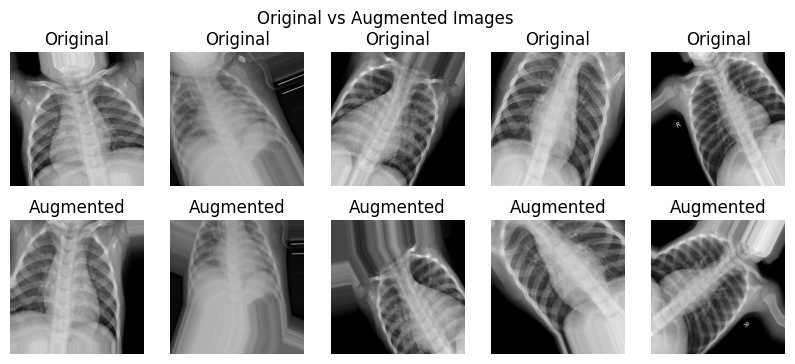

🚀 Training EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7840 - loss: 0.4423

156/156 ━━━━━━━━━━━━━━━━━━━━ 1858s 11s/step - accuracy: 0.7844 - loss: 0.4417 - val_accuracy: 0.7298 - val_loss: 0.6194 - learning_rate: 1.0000e-04
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 124s 794ms/step - accuracy: 0.8832 - loss: 0.2760 - val_accuracy: 0.7298 - val_loss: 0.6199 - learning_rate: 1.0000e-04
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.8957 - loss: 0.2487

156/156 ━━━━━━━━━━━━━━━━━━━━ 126s 808ms/step - accuracy: 0.8957 - loss: 0.2486 - val_accuracy: 0.7320 - val_loss: 0.6801 - learning_rate: 1.0000e-04
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.9123 - loss: 0.2114

156/156 ━━━━━━━━━━━━━━━━━━━━ 124s 792ms/step - accuracy: 0.9123 - loss: 0.2114 - val_accuracy: 0.9339 - val_loss: 0.1987 - learning_rate: 1.0000e-04
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 141s 786ms/step - accuracy: 0.9241 - loss: 0.1882 - val_accuracy: 0.9236 - val_loss: 0.1938 - learning_rate: 1.0000e-04
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.9300 - loss: 0.1836

156/156 ━━━━━━━━━━━━━━━━━━━━ 124s 793ms/step - accuracy: 0.9300 - loss: 0.1835 - val_accuracy: 0.9384 - val_loss: 0.1675 - learning_rate: 1.0000e-04
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 123s 792ms/step - accuracy: 0.9303 - loss: 0.1781 - val_accuracy: 0.9213 - val_loss: 0.2170 - learning_rate: 1.0000e-04
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 125s 802ms/step - accuracy: 0.9384 - loss: 0.1635 - val_accuracy: 0.9316 - val_loss: 0.1852 - learning_rate: 1.0000e-04
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 123s 791ms/step - accuracy: 0.9350 - loss: 0.1561 - val_accuracy: 0.9350 - val_loss: 0.1732 - learning_rate: 1.0000e-04
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9458 - loss: 0.1325

156/156 ━━━━━━━━━━━━━━━━━━━━ 123s 788ms/step - accuracy: 0.9458 - loss: 0.1325 - val_accuracy: 0.9475 - val_loss: 0.1409 - learning_rate: 2.0000e-05
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.9492 - loss: 0.1333

156/156 ━━━━━━━━━━━━━━━━━━━━ 125s 800ms/step - accuracy: 0.9492 - loss: 0.1333 - val_accuracy: 0.9555 - val_loss: 0.1291 - learning_rate: 2.0000e-05
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 123s 789ms/step - accuracy: 0.9537 - loss: 0.1268 - val_accuracy: 0.9498 - val_loss: 0.1291 - learning_rate: 2.0000e-05
Epoch 13/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 124s 794ms/step - accuracy: 0.9499 - loss: 0.1263 - val_accuracy: 0.9510 - val_loss: 0.1251 - learning_rate: 2.0000e-05
Epoch 14/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 124s 792ms/step - accuracy: 0.9553 - loss: 0.1272 - val_accuracy: 0.9544 - val_loss: 0.1286 - learning_rate: 2.0000e-05
Epoch 15/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 125s 800ms/step - accuracy: 0.9567 - loss: 0.1107 - val_accuracy: 0.9498 - val_loss: 0.1269 - learning_rate: 2.0000e-05
Epoch 16/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 140s 788ms/step - accuracy: 0.9580 - loss: 0.1114 - val_accuracy: 0.9521 - val_loss: 0.1237 - learning_rate: 2.0000e-05
Epoch 17/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 123s 

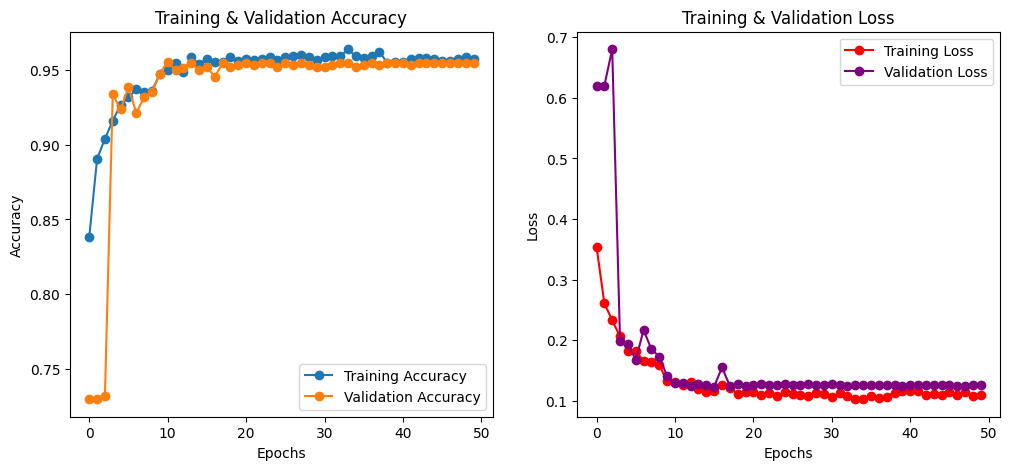


📊 Evaluating EfficientNetB0 Model...


28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 597ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.90      0.92       237
   PNEUMONIA       0.96      0.98      0.97       640

    accuracy                           0.96       877
   macro avg       0.95      0.94      0.94       877
weighted avg       0.96      0.96      0.96       877



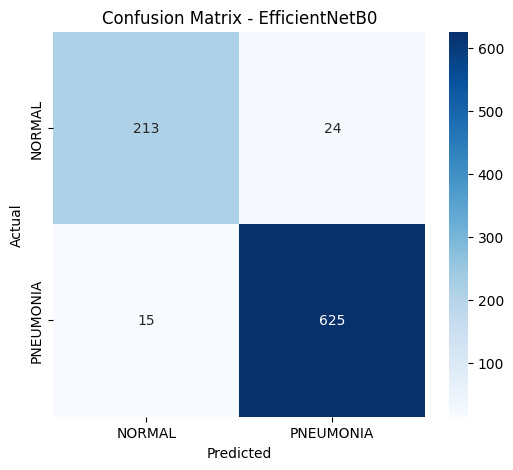

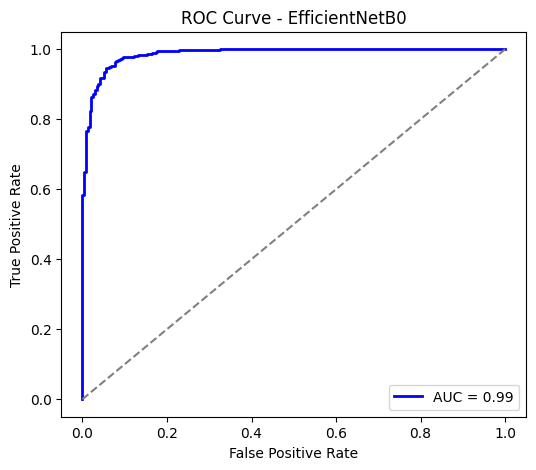

📌 EfficientNetB0 AUC Score: 0.9871


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Define dataset directories
data_dir = r"/content/drive/MyDrive/split chest"  # Update with correct path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Verify dataset paths exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("❌ ERROR: Train or test directory not found! Check the dataset path.")

# Image Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset with binary classification
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# Function to visualize data augmentation
def visualize_augmentation(generator, num_images=5):
    """Displays original and augmented images."""
    sample_images, _ = next(generator)  # Get a batch of images
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        img = sample_images[i]  # Original image
        augmented_img = train_datagen.random_transform(img)  # Apply augmentation

        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Original")

        # Display augmented image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(augmented_img)
        plt.axis("off")
        plt.title("Augmented")

    plt.suptitle("Original vs Augmented Images")
    plt.show()

# Function to create and fine-tune EfficientNetB0 model
def create_model(fine_tune_at=50):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze all layers

    # Freeze first few layers and fine-tune deeper layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
    output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate():
    print("🚀 Training EfficientNetB0 model...")

    model = create_model()

    # Define callbacks
    checkpoint = ModelCheckpoint("EfficientNetB0_best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

    # Train model for exactly 50 epochs (no early stopping)
    history = model.fit(
        train_generator, epochs=50, validation_data=test_generator, callbacks=[checkpoint, reduce_lr])

    print("✅ EfficientNetB0 model training complete! Best model saved as 'EfficientNetB0_best_model.h5'")

    # Plot Training & Validation Accuracy and Loss
    plot_training_history(history)

    evaluate_model()

# Function to plot training history
def plot_training_history(history):
    """Plots training & validation accuracy and loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

# Function to evaluate a trained EfficientNetB0 model
def evaluate_model():
    print("\n📊 Evaluating EfficientNetB0 Model...")

    # Load the best saved model
    model = tf.keras.models.load_model("EfficientNetB0_best_model.h5")

    # Get ground truth labels and predictions
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    # Compute evaluation metrics
    print("\n🔍 Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - EfficientNetB0")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - EfficientNetB0')
    plt.legend(loc='lower right')
    plt.show()

    print(f"📌 EfficientNetB0 AUC Score: {roc_auc:.4f}")

# Run augmentation visualization, training, and evaluation
visualize_augmentation(train_generator)
train_and_evaluate()


Found 4970 images belonging to 2 classes.
Found 876 images belonging to 2 classes.
🚀 Training InceptionV3 model...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.6660 - loss: 0.5967

156/156 ━━━━━━━━━━━━━━━━━━━━ 221s 985ms/step - accuracy: 0.6667 - loss: 0.5960 - val_accuracy: 0.8447 - val_loss: 0.3728 - learning_rate: 1.0000e-05
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.8962 - loss: 0.2839

156/156 ━━━━━━━━━━━━━━━━━━━━ 110s 704ms/step - accuracy: 0.8962 - loss: 0.2838 - val_accuracy: 0.9144 - val_loss: 0.2411 - learning_rate: 1.0000e-05
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9235 - loss: 0.2095

156/156 ━━━━━━━━━━━━━━━━━━━━ 109s 700ms/step - accuracy: 0.9235 - loss: 0.2094 - val_accuracy: 0.9304 - val_loss: 0.1995 - learning_rate: 1.0000e-05
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9311 - loss: 0.1865

156/156 ━━━━━━━━━━━━━━━━━━━━ 110s 706ms/step - accuracy: 0.9311 - loss: 0.1864 - val_accuracy: 0.9326 - val_loss: 0.1754 - learning_rate: 1.0000e-05
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9348 - loss: 0.1642

156/156 ━━━━━━━━━━━━━━━━━━━━ 143s 710ms/step - accuracy: 0.9348 - loss: 0.1642 - val_accuracy: 0.9463 - val_loss: 0.1634 - learning_rate: 1.0000e-05
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 108s 694ms/step - accuracy: 0.9526 - loss: 0.1282 - val_accuracy: 0.9429 - val_loss: 0.1617 - learning_rate: 1.0000e-05
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9539 - loss: 0.1285

156/156 ━━━━━━━━━━━━━━━━━━━━ 110s 702ms/step - accuracy: 0.9538 - loss: 0.1285 - val_accuracy: 0.9509 - val_loss: 0.1443 - learning_rate: 1.0000e-05
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 110s 705ms/step - accuracy: 0.9523 - loss: 0.1275 - val_accuracy: 0.9452 - val_loss: 0.1530 - learning_rate: 1.0000e-05
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 107s 686ms/step - accuracy: 0.9539 - loss: 0.1254 - val_accuracy: 0.9463 - val_loss: 0.1471 - learning_rate: 1.0000e-05
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9593 - loss: 0.1083

156/156 ━━━━━━━━━━━━━━━━━━━━ 113s 723ms/step - accuracy: 0.9593 - loss: 0.1083 - val_accuracy: 0.9566 - val_loss: 0.1297 - learning_rate: 1.0000e-05
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9634 - loss: 0.0942

156/156 ━━━━━━━━━━━━━━━━━━━━ 108s 695ms/step - accuracy: 0.9634 - loss: 0.0943 - val_accuracy: 0.9589 - val_loss: 0.1215 - learning_rate: 1.0000e-05
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 141s 687ms/step - accuracy: 0.9625 - loss: 0.1049 - val_accuracy: 0.9338 - val_loss: 0.1720 - learning_rate: 1.0000e-05
Epoch 13/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 107s 684ms/step - accuracy: 0.9588 - loss: 0.1045 - val_accuracy: 0.9429 - val_loss: 0.1655 - learning_rate: 1.0000e-05
Epoch 14/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 107s 684ms/step - accuracy: 0.9645 - loss: 0.0978 - val_accuracy: 0.9441 - val_loss: 0.1582 - learning_rate: 1.0000e-05
Epoch 15/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 108s 693ms/step - accuracy: 0.9676 - loss: 0.0961 - val_accuracy: 0.9429 - val_loss: 0.1577 - learning_rate: 2.0000e-06
Epoch 16/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 109s 699ms/step - accuracy: 0.9704 - loss: 0.0823 - val_accuracy: 0.9452 - val_loss: 0.1537 - learning_rate: 2.0000e-06
Epoch 17/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 107s 

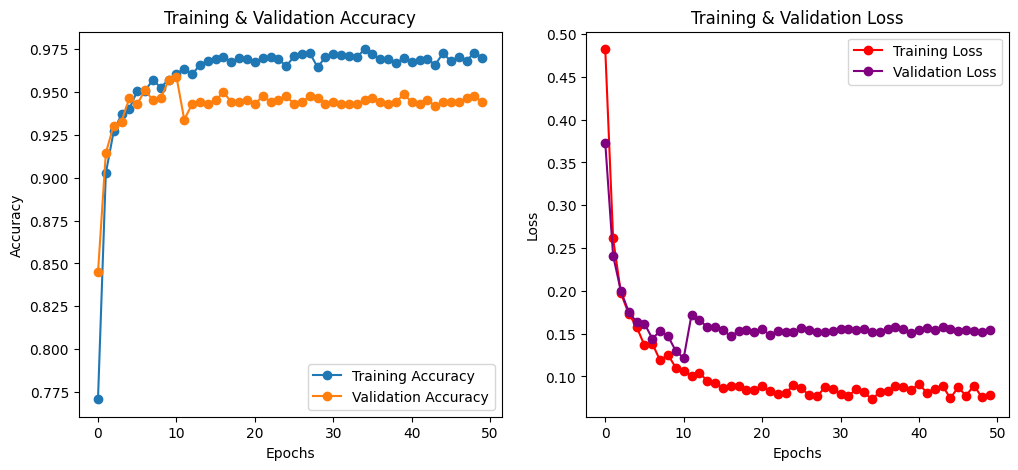


📊 Evaluating InceptionV3 Model...


28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 432ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.96      0.93       236
   PNEUMONIA       0.98      0.96      0.97       640

    accuracy                           0.96       876
   macro avg       0.94      0.96      0.95       876
weighted avg       0.96      0.96      0.96       876



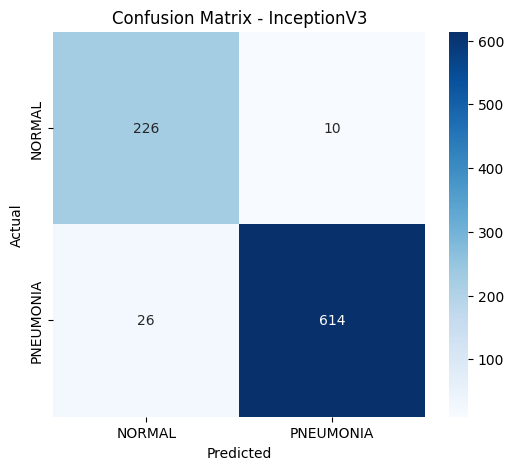

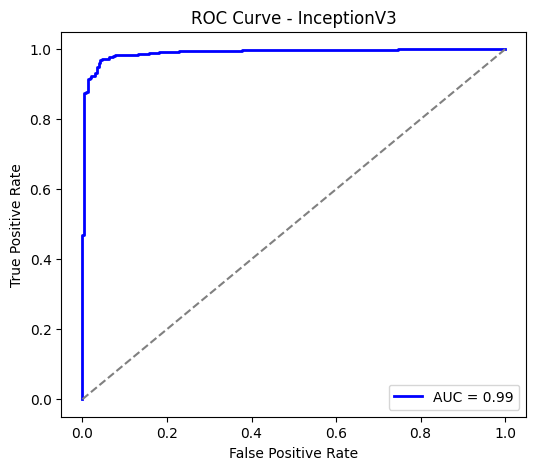

📌 InceptionV3 AUC Score: 0.9904


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Define dataset directories
data_dir = r"/content/pne"  # Update with correct path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Verify dataset paths exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("❌ ERROR: Train or test directory not found! Check the dataset path.")

# Image Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset with binary classification
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# Function to create and fine-tune InceptionV3 model
def create_model(fine_tune_at=50):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Function to train and evaluate model
def train_and_evaluate():
    print("🚀 Training InceptionV3 model...")
    model = create_model()
    checkpoint = ModelCheckpoint("InceptionV3_best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

    history = model.fit(
        train_generator, epochs=50, validation_data=test_generator, callbacks=[checkpoint, reduce_lr])

    print("✅ InceptionV3 model training complete! Best model saved as 'InceptionV3_best_model.h5'")
    plot_training_history(history)
    evaluate_model()

# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

# Function to evaluate a trained InceptionV3 model
def evaluate_model():
    print("\n📊 Evaluating InceptionV3 Model...")
    model = tf.keras.models.load_model("InceptionV3_best_model.h5")
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    print("\n🔍 Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=test_generator.class_indices.keys(),
                 yticklabels=test_generator.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - InceptionV3")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - InceptionV3')
    plt.legend(loc='lower right')
    plt.show()

    print(f"📌 InceptionV3 AUC Score: {roc_auc:.4f}")

# Run training and evaluation
train_and_evaluate()


Found 4970 images belonging to 2 classes.
Found 876 images belonging to 2 classes.


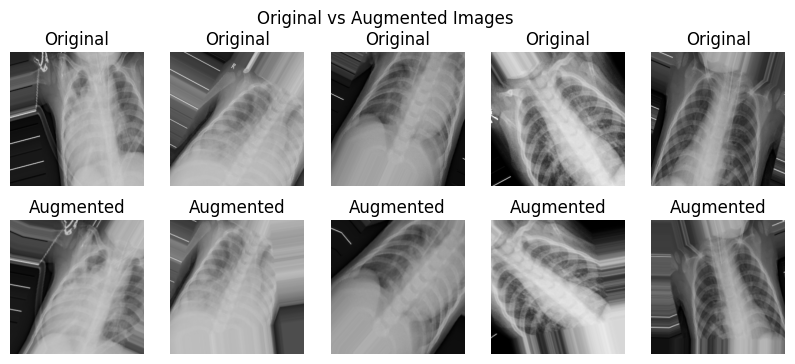

🚀 Training AlexNet model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.7277 - loss: 0.6095

156/156 ━━━━━━━━━━━━━━━━━━━━ 132s 776ms/step - accuracy: 0.7277 - loss: 0.6093 - val_accuracy: 0.7306 - val_loss: 0.5094 - learning_rate: 1.0000e-05
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.7612 - loss: 0.4784

156/156 ━━━━━━━━━━━━━━━━━━━━ 109s 697ms/step - accuracy: 0.7615 - loss: 0.4781 - val_accuracy: 0.8904 - val_loss: 0.2890 - learning_rate: 1.0000e-05
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 102s 654ms/step - accuracy: 0.8624 - loss: 0.3209 - val_accuracy: 0.8242 - val_loss: 0.3660 - learning_rate: 1.0000e-05
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8614 - loss: 0.3089

156/156 ━━━━━━━━━━━━━━━━━━━━ 107s 685ms/step - accuracy: 0.8614 - loss: 0.3088 - val_accuracy: 0.9030 - val_loss: 0.2514 - learning_rate: 1.0000e-05
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 137s 654ms/step - accuracy: 0.8820 - loss: 0.2876 - val_accuracy: 0.9018 - val_loss: 0.2533 - learning_rate: 1.0000e-05
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 102s 653ms/step - accuracy: 0.8841 - loss: 0.2733 - val_accuracy: 0.8162 - val_loss: 0.3856 - learning_rate: 1.0000e-05
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8789 - loss: 0.2842

156/156 ━━━━━━━━━━━━━━━━━━━━ 115s 739ms/step - accuracy: 0.8790 - loss: 0.2841 - val_accuracy: 0.9189 - val_loss: 0.2241 - learning_rate: 1.0000e-05
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 131s 668ms/step - accuracy: 0.8920 - loss: 0.2595 - val_accuracy: 0.9087 - val_loss: 0.2459 - learning_rate: 1.0000e-05
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 101s 647ms/step - accuracy: 0.8958 - loss: 0.2557 - val_accuracy: 0.8927 - val_loss: 0.2563 - learning_rate: 1.0000e-05
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 142s 649ms/step - accuracy: 0.9072 - loss: 0.2351 - val_accuracy: 0.8824 - val_loss: 0.2724 - learning_rate: 1.0000e-05
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 142s 653ms/step - accuracy: 0.9081 - loss: 0.2249 - val_accuracy: 0.9098 - val_loss: 0.2329 - learning_rate: 2.0000e-06
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 106s 681ms/step - accuracy: 0.9132 - loss: 0.2225 - val_accuracy: 0.9030 - val_loss: 0.2392 - learning_rate: 2.0000e-06
Epoch 13/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 102s 65

156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 718ms/step - accuracy: 0.9135 - loss: 0.2103 - val_accuracy: 0.9224 - val_loss: 0.2030 - learning_rate: 4.0000e-07
Epoch 17/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 103s 657ms/step - accuracy: 0.9182 - loss: 0.2092 - val_accuracy: 0.9178 - val_loss: 0.2112 - learning_rate: 4.0000e-07
Epoch 18/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 102s 653ms/step - accuracy: 0.9164 - loss: 0.2266 - val_accuracy: 0.9121 - val_loss: 0.2261 - learning_rate: 4.0000e-07
Epoch 19/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9254 - loss: 0.2050

156/156 ━━━━━━━━━━━━━━━━━━━━ 106s 679ms/step - accuracy: 0.9253 - loss: 0.2051 - val_accuracy: 0.9235 - val_loss: 0.2007 - learning_rate: 4.0000e-07
Epoch 20/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9147 - loss: 0.2134

156/156 ━━━━━━━━━━━━━━━━━━━━ 108s 695ms/step - accuracy: 0.9147 - loss: 0.2134 - val_accuracy: 0.9258 - val_loss: 0.2023 - learning_rate: 4.0000e-07
Epoch 21/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 102s 654ms/step - accuracy: 0.9149 - loss: 0.2232 - val_accuracy: 0.9121 - val_loss: 0.2241 - learning_rate: 4.0000e-07
Epoch 22/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 102s 655ms/step - accuracy: 0.9114 - loss: 0.2188 - val_accuracy: 0.9155 - val_loss: 0.2118 - learning_rate: 4.0000e-07
Epoch 23/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 102s 654ms/step - accuracy: 0.9193 - loss: 0.2162 - val_accuracy: 0.9178 - val_loss: 0.2061 - learning_rate: 1.0000e-07
Epoch 24/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 103s 656ms/step - accuracy: 0.9196 - loss: 0.2144 - val_accuracy: 0.9178 - val_loss: 0.2046 - learning_rate: 1.0000e-07
Epoch 25/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 103s 658ms/step - accuracy: 0.9192 - loss: 0.2065 - val_accuracy: 0.9178 - val_loss: 0.2078 - learning_rate: 1.0000e-07
Epoch 26/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 105s 

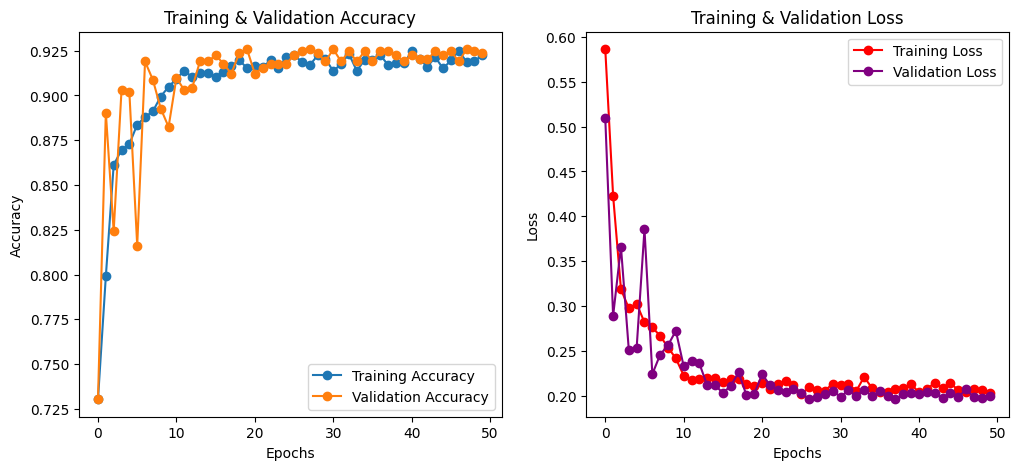


📊 Evaluating AlexNet Model...


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.81      0.94      0.87       236
   PNEUMONIA       0.98      0.92      0.95       640

    accuracy                           0.93       876
   macro avg       0.89      0.93      0.91       876
weighted avg       0.93      0.93      0.93       876



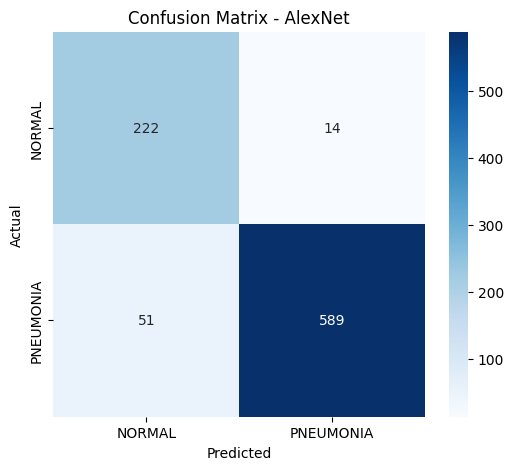

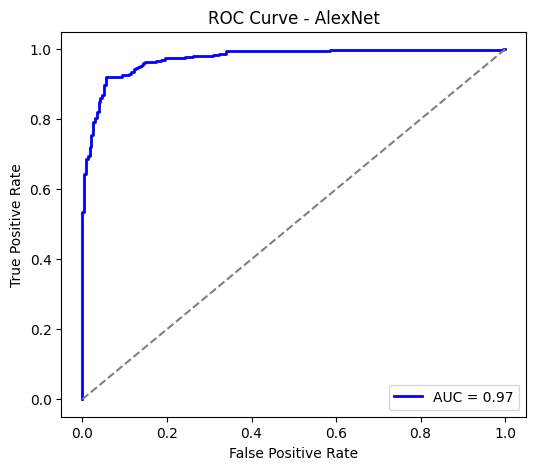

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Define dataset directories
data_dir = r"/content/pne"  # Update with correct path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Verify dataset paths exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("❌ ERROR: Train or test directory not found! Check the dataset path.")

# Image Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset with binary classification
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(227, 227), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(227, 227), batch_size=32, class_mode='binary', shuffle=False)

# Function to visualize data augmentation
def visualize_augmentation(generator, num_images=5):
    sample_images, _ = next(generator)  # Get a batch of images
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        img = sample_images[i]  # Original image
        augmented_img = train_datagen.random_transform(img)  # Apply augmentation

        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Original")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(augmented_img)
        plt.axis("off")
        plt.title("Augmented")

    plt.suptitle("Original vs Augmented Images")
    plt.show()

# Function to create AlexNet model
def create_model():
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(227, 227, 3)),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(256, (5, 5), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate():
    print("🚀 Training AlexNet model...")
    model = create_model()

    checkpoint = ModelCheckpoint("AlexNet_best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

    history = model.fit(
        train_generator, epochs=50, validation_data=test_generator, callbacks=[checkpoint, reduce_lr])

    print("✅ AlexNet model training complete! Best model saved as 'AlexNet_best_model.h5'")
    plot_training_history(history)
    evaluate_model()

# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    plt.show()

# Function to evaluate AlexNet model
def evaluate_model():
    print("\n📊 Evaluating AlexNet Model...")
    model = tf.keras.models.load_model("AlexNet_best_model.h5")
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    print("\n🔍 Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - AlexNet")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - AlexNet')
    plt.legend(loc='lower right')
    plt.show()

# Run augmentation visualization, training, and evaluation
visualize_augmentation(train_generator)
train_and_evaluate()


Found 4977 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


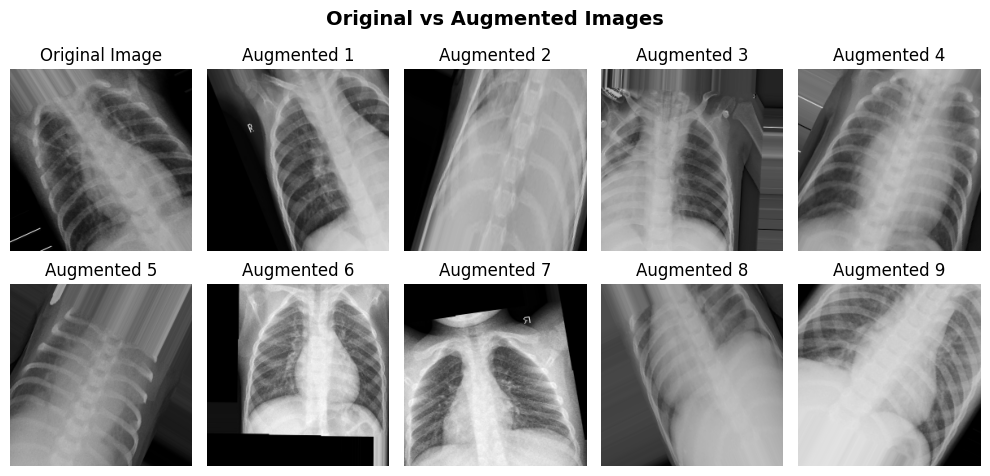

🚀 Training ResNet50 model...
Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7709 - loss: 0.4568

156/156 ━━━━━━━━━━━━━━━━━━━━ 683s 4s/step - accuracy: 0.7713 - loss: 0.4563 - val_accuracy: 0.7309 - val_loss: 0.5717 - learning_rate: 1.0000e-05
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8722 - loss: 0.2793

156/156 ━━━━━━━━━━━━━━━━━━━━ 133s 849ms/step - accuracy: 0.8723 - loss: 0.2793 - val_accuracy: 0.7845 - val_loss: 0.4271 - learning_rate: 1.0000e-05
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8980 - loss: 0.2325

156/156 ━━━━━━━━━━━━━━━━━━━━ 138s 832ms/step - accuracy: 0.8980 - loss: 0.2325 - val_accuracy: 0.8643 - val_loss: 0.3552 - learning_rate: 1.0000e-05
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 127s 816ms/step - accuracy: 0.9161 - loss: 0.2110 - val_accuracy: 0.8096 - val_loss: 0.4181 - learning_rate: 1.0000e-05
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.9308 - loss: 0.1979

156/156 ━━━━━━━━━━━━━━━━━━━━ 152s 881ms/step - accuracy: 0.9308 - loss: 0.1979 - val_accuracy: 0.8860 - val_loss: 0.2783 - learning_rate: 1.0000e-05
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 134s 830ms/step - accuracy: 0.9329 - loss: 0.1846 - val_accuracy: 0.8837 - val_loss: 0.2705 - learning_rate: 1.0000e-05
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.9284 - loss: 0.1835

156/156 ━━━━━━━━━━━━━━━━━━━━ 130s 834ms/step - accuracy: 0.9285 - loss: 0.1835 - val_accuracy: 0.9225 - val_loss: 0.2079 - learning_rate: 1.0000e-05
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 127s 811ms/step - accuracy: 0.9364 - loss: 0.1597 - val_accuracy: 0.8917 - val_loss: 0.2549 - learning_rate: 1.0000e-05
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.9341 - loss: 0.1671

156/156 ━━━━━━━━━━━━━━━━━━━━ 129s 829ms/step - accuracy: 0.9341 - loss: 0.1671 - val_accuracy: 0.9487 - val_loss: 0.1565 - learning_rate: 1.0000e-05
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 140s 815ms/step - accuracy: 0.9500 - loss: 0.1367 - val_accuracy: 0.9453 - val_loss: 0.1334 - learning_rate: 1.0000e-05
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 141s 807ms/step - accuracy: 0.9410 - loss: 0.1506 - val_accuracy: 0.9453 - val_loss: 0.1421 - learning_rate: 1.0000e-05
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.9454 - loss: 0.1385

156/156 ━━━━━━━━━━━━━━━━━━━━ 144s 822ms/step - accuracy: 0.9454 - loss: 0.1385 - val_accuracy: 0.9567 - val_loss: 0.1100 - learning_rate: 1.0000e-05
Epoch 13/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 128s 820ms/step - accuracy: 0.9471 - loss: 0.1249 - val_accuracy: 0.9487 - val_loss: 0.1490 - learning_rate: 1.0000e-05
Epoch 14/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 141s 813ms/step - accuracy: 0.9469 - loss: 0.1436 - val_accuracy: 0.8814 - val_loss: 0.3331 - learning_rate: 1.0000e-05
Epoch 15/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 126s 808ms/step - accuracy: 0.9513 - loss: 0.1199 - val_accuracy: 0.7400 - val_loss: 0.6049 - learning_rate: 1.0000e-05
Epoch 16/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 137s 876ms/step - accuracy: 0.9556 - loss: 0.1161 - val_accuracy: 0.9190 - val_loss: 0.2136 - learning_rate: 2.0000e-06
Epoch 17/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 133s 815ms/step - accuracy: 0.9583 - loss: 0.1212 - val_accuracy: 0.9133 - val_loss: 0.2567 - learning_rate: 2.0000e-06
Epoch 18/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 127s 

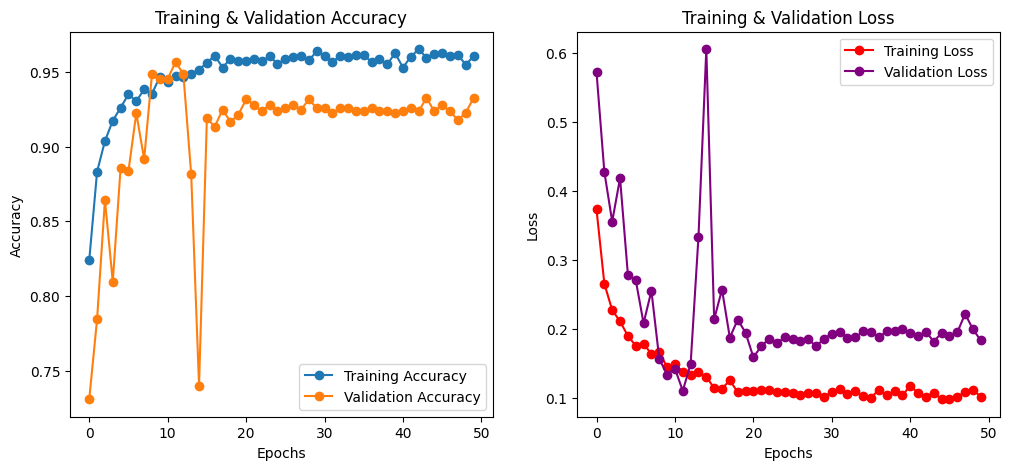


📊 Evaluating ResNet50 Model...


28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.89      0.92       237
   PNEUMONIA       0.96      0.98      0.97       640

    accuracy                           0.96       877
   macro avg       0.95      0.94      0.94       877
weighted avg       0.96      0.96      0.96       877


📂 Classification report saved as 'classification_report.txt'


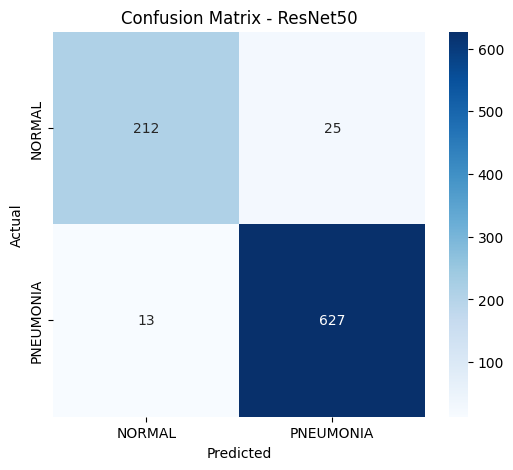

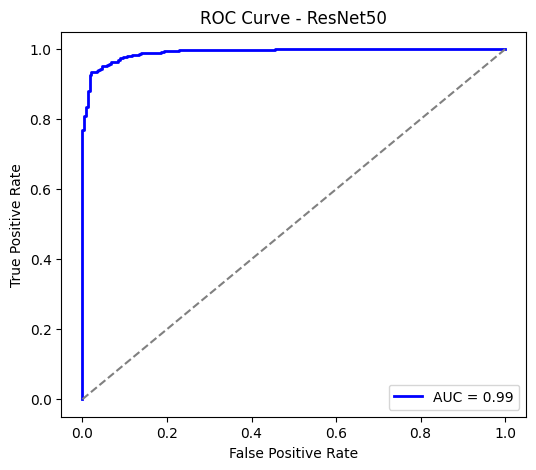

📌 ResNet50 AUC Score: 0.9913


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# ============== DATASET LOADING ==============

# Define dataset directories (UPDATE path if needed)
data_dir = r"/content/drive/MyDrive/split chest"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Verify dataset paths exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("❌ ERROR: Train or test directory not found! Check the dataset path.")

# ============== IMAGE PREPROCESSING & AUGMENTATION ==============

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset with binary classification
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# ============== MODEL CREATION & TRAINING ==============

def create_model(fine_tune_at=50):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze all layers

    # Freeze first few layers and fine-tune deeper layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
    output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate():
    print("🚀 Training ResNet50 model...")

    model = create_model()

    # Define callbacks
    checkpoint = ModelCheckpoint("ResNet50_best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

    # Train model for exactly 50 epochs
    history = model.fit(
        train_generator, epochs=50, validation_data=test_generator, callbacks=[checkpoint, reduce_lr])

    print("✅ ResNet50 model training complete! Best model saved as 'ResNet50_best_model.h5'")

    # Plot Training & Validation Accuracy and Loss
    plot_training_history(history)

    evaluate_model()

# ============== TRAINING HISTORY PLOT ==============

def plot_training_history(history):
    """Plots training & validation accuracy and loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

# ============== MODEL EVALUATION ==============

def evaluate_model():
    print("\n📊 Evaluating ResNet50 Model...")

    model_path = "ResNet50_best_model.h5"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"❌ ERROR: Model file '{model_path}' not found!")

    # Load the best saved model
    model = tf.keras.models.load_model(model_path)

    # Get ground truth labels and predictions
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    # Compute evaluation metrics
    print("\n🔍 Classification Report:")
    class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
    print(class_report)

    # Save classification report
    with open("classification_report.txt", "w") as f:
        f.write(class_report)
    print("\n📂 Classification report saved as 'classification_report.txt'")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - ResNet50")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ResNet50')
    plt.legend(loc='lower right')
    plt.show()

    print(f"📌 ResNet50 AUC Score: {roc_auc:.4f}")

# ============== DISPLAY ORIGINAL & AUGMENTED IMAGES ==============

def show_augmented_images():
    """Displays one original image and multiple augmented versions."""
    img, label = next(train_generator)  # Get a random image from training data

    plt.figure(figsize=(10, 5))
    plt.subplot(2, 5, 1)
    plt.imshow(img[0])
    plt.title("Original Image")
    plt.axis("off")

    for i in range(9):
        img_aug, _ = next(train_generator)
        plt.subplot(2, 5, i + 2)
        plt.imshow(img_aug[0])
        plt.title(f"Augmented {i+1}")
        plt.axis("off")

    plt.suptitle("Original vs Augmented Images", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ============== RUN TRAINING & EVALUATION ==============
if __name__ == "__main__":
    show_augmented_images()  # Display data augmentation preview
    train_and_evaluate()  # Train & evaluate model
